This notebook contains BDT variables' distribution from events of control region in data.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets_=json.load(open('../Samples/control_data2018.json'))
datasets = dict(
    A={'files': datasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'},
    B={'files': datasets_['B'], 'treename': 'ffNtuples/ffNtuple'},
    C={'files': datasets_['C'], 'treename': 'ffNtuples/ffNtuple'},
    D={'files': datasets_['D'], 'treename': 'ffNtuples/ffNtuple'},
)

## First, make sure this is control region, aka,
- At least 2 leptonJets
- deltaPhi of leading and subleading leptonJets < 2.5

In [3]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        dphi_axis = hist.Bin("dphi", "$\Delta\Phi$(leading, subleading) leptonJets", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "dphi": hist.Hist("#counts/$\pi$/50", dataset_axis, dphi_axis)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets.counts)
        
        twoljs = leptonjets.counts>=2
        diljs = leptonjets[twoljs]
        diljs = diljs.distincts()
        sumpt = diljs.i0.pt+diljs.i1.pt
        leadDiLjpair = diljs[sumpt.argmax()]
        absdphi = np.abs(leadDiLjpair.i0.p4.delta_phi(leadDiLjpair.i1.p4))
        
        output['dphi'].fill(dataset=dataset, dphi=absdphi.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2545/2545 [01:42<00:00, 24.93items/s]


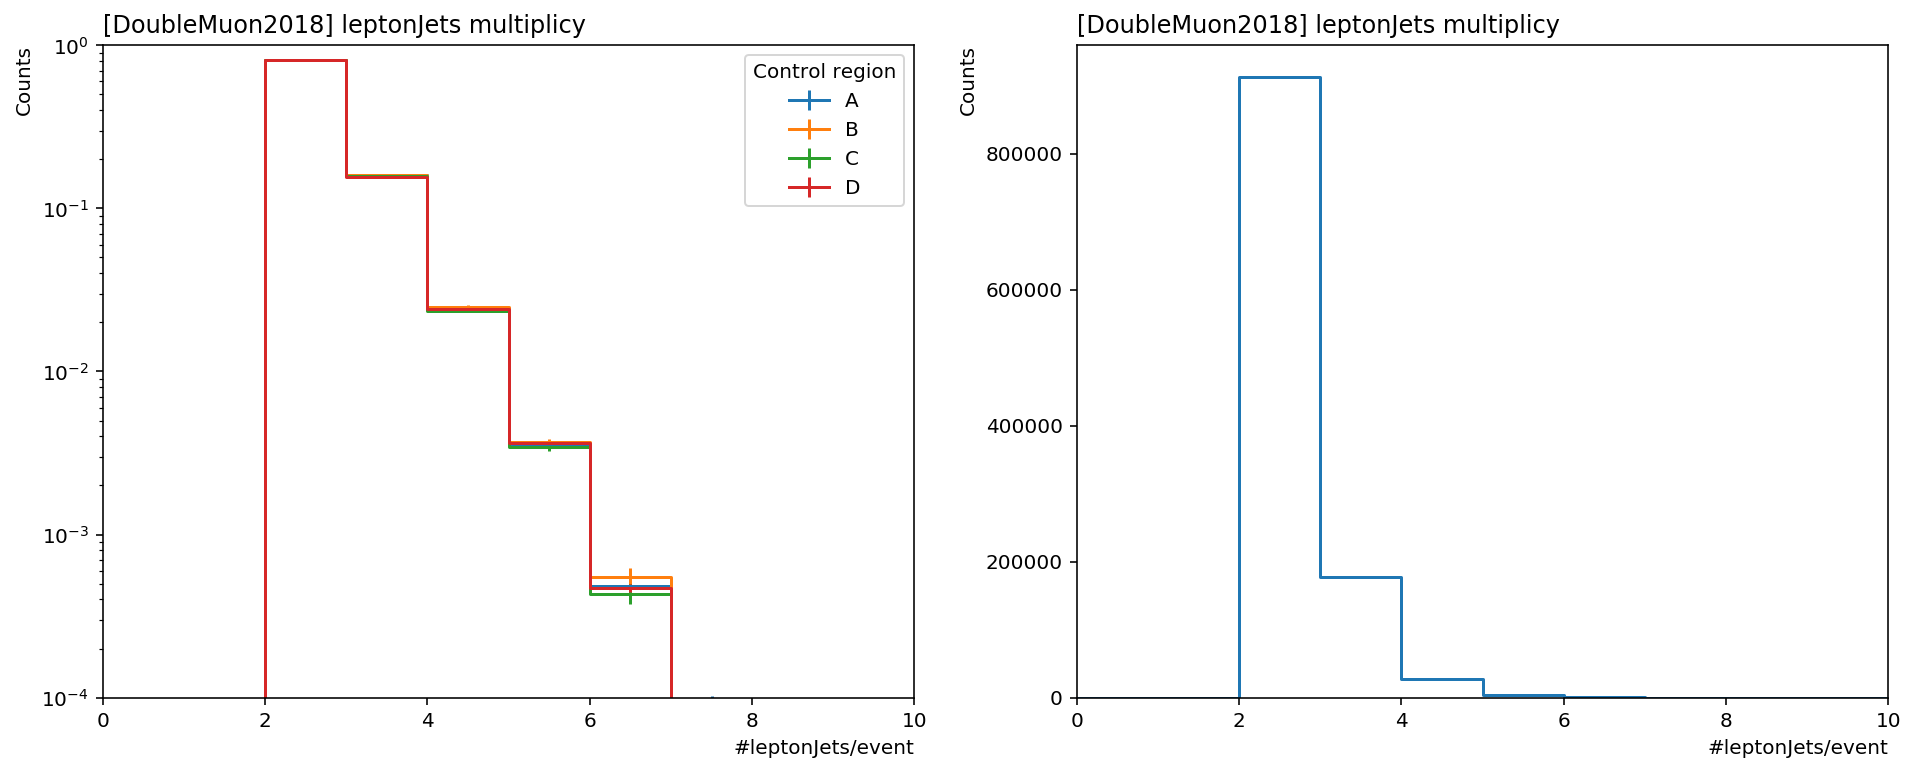

In [6]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['multi'], ax=ax[0], overlay='dataset', density=True)
hist.plot1d(output['multi'].sum('dataset'), ax=ax[1])

ax[0].set_ylim([1e-4, 1])
ax[0].set_yscale('log')

for a in ax:
    a.set_title('[DoubleMuon2018] leptonJets multiplicy', x=0.0, ha="left")
    a.set_xlabel(a.get_xlabel(), x=1.0, ha="right")
    a.set_ylabel(a.get_ylabel(), y=1.0, ha="right");

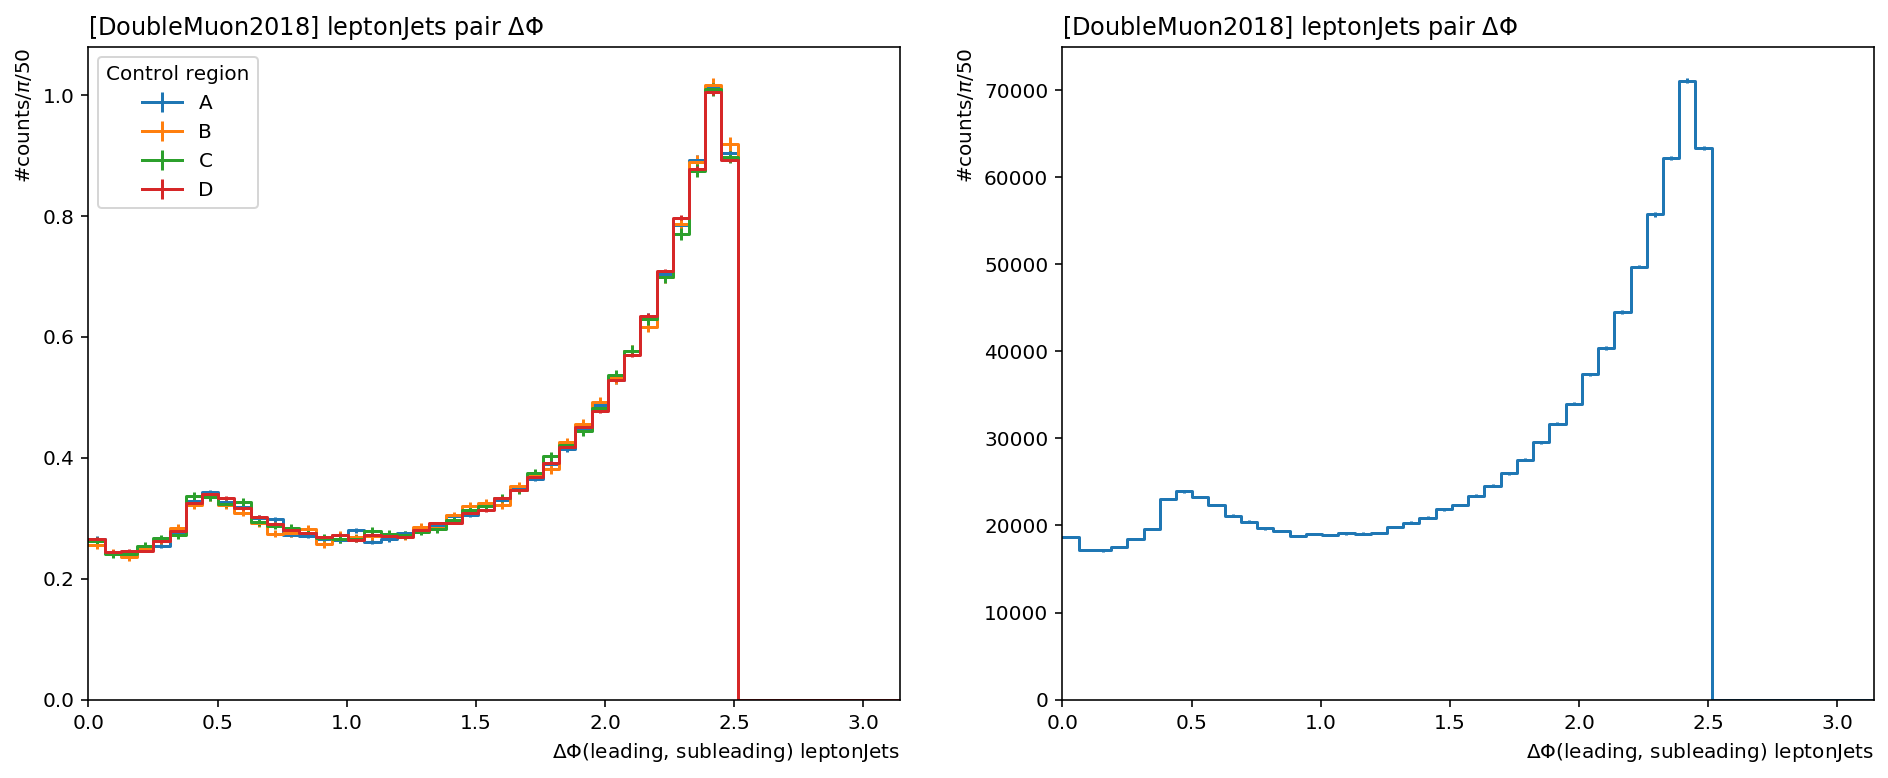

In [7]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['dphi'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['dphi'].sum('dataset'), ax=axes[1])

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets pair $\Delta\Phi$', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [8]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis),
            "ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis),
            "ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_=np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_=np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
#             maxd0=JaggedArray.fromjagged(maxd0_),
#             mind0=JaggedArray.fromjagged(mind0_),
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )

        output['pt'].fill(dataset=dataset, pt=leptonjets.pt.flatten())
        output['eta'].fill(dataset=dataset, eta=leptonjets.eta.flatten())
        output['nef'].fill(dataset=dataset, nef=leptonjets.nef.flatten())
        output['maxd0'].fill(dataset=dataset, maxd0=maxd0_.flatten())
        output['mind0'].fill(dataset=dataset, mind0=mind0_.flatten())
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets.tkiso.flatten())
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets.spreaddr.flatten())
        output['lamb'].fill(dataset=dataset, lamb=leptonjets.lamb.flatten())
        output['epsi'].fill(dataset=dataset, epsi=leptonjets.epsi.flatten())
        output['ecfe1'].fill(dataset=dataset, ecfe1=leptonjets.ecf1.flatten())
        output['ecfe2'].fill(dataset=dataset, ecfe2=leptonjets.ecf2.flatten())
        output['ecfe3'].fill(dataset=dataset, ecfe3=leptonjets.ecf3.flatten())
        output['mva'].fill(dataset=dataset, mva=leptonjets.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [9]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2545/2545 [02:55<00:00, 14.52items/s]


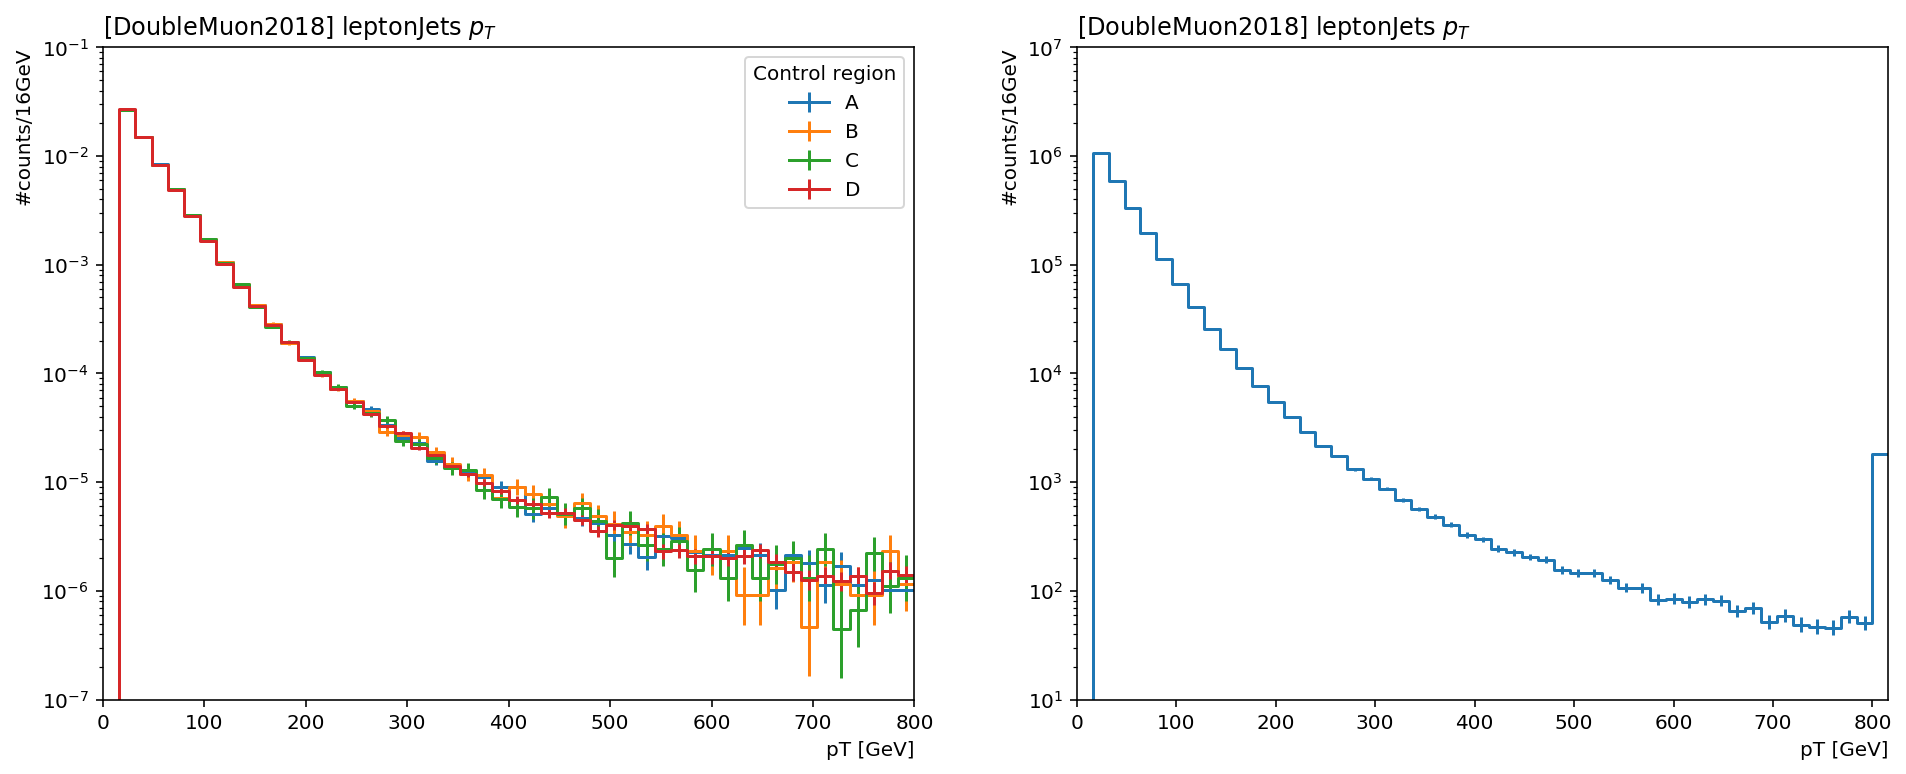

In [11]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['pt'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['pt'].sum('dataset'), ax=axes[1], overflow='over')

axes[0].set_yscale('log')
axes[0].set_ylim([1e-7, 1e-1])

axes[1].set_yscale('log')
axes[1].set_ylim([1e1, 1e7])

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets $p_T$', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

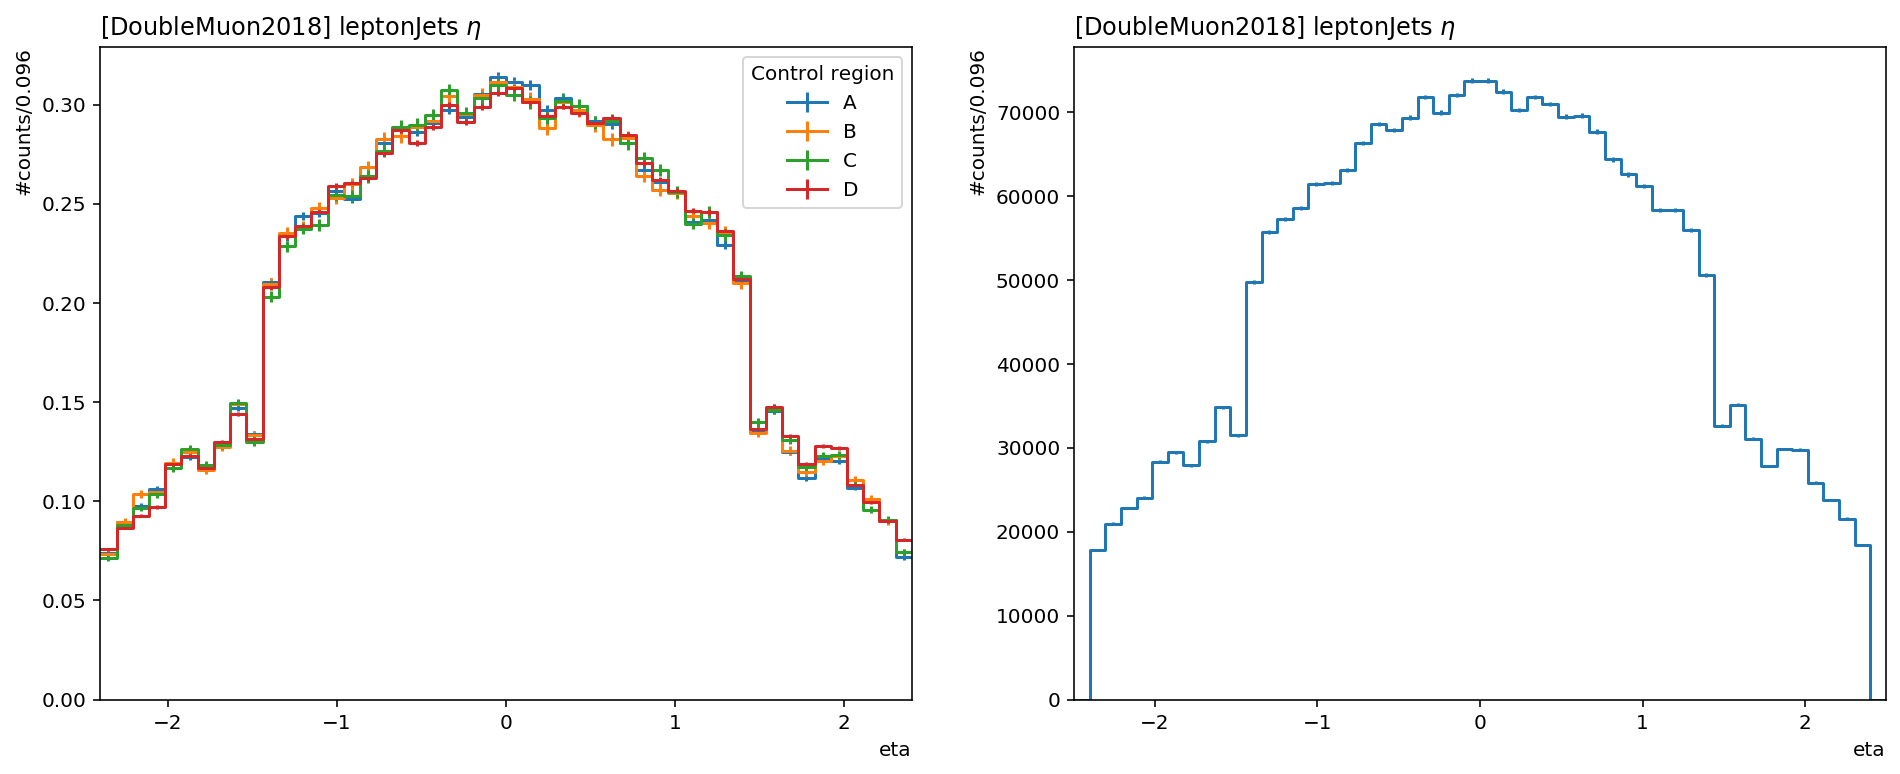

In [12]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['eta'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['eta'].sum('dataset'), ax=axes[1], overflow='all')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets $\eta$', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

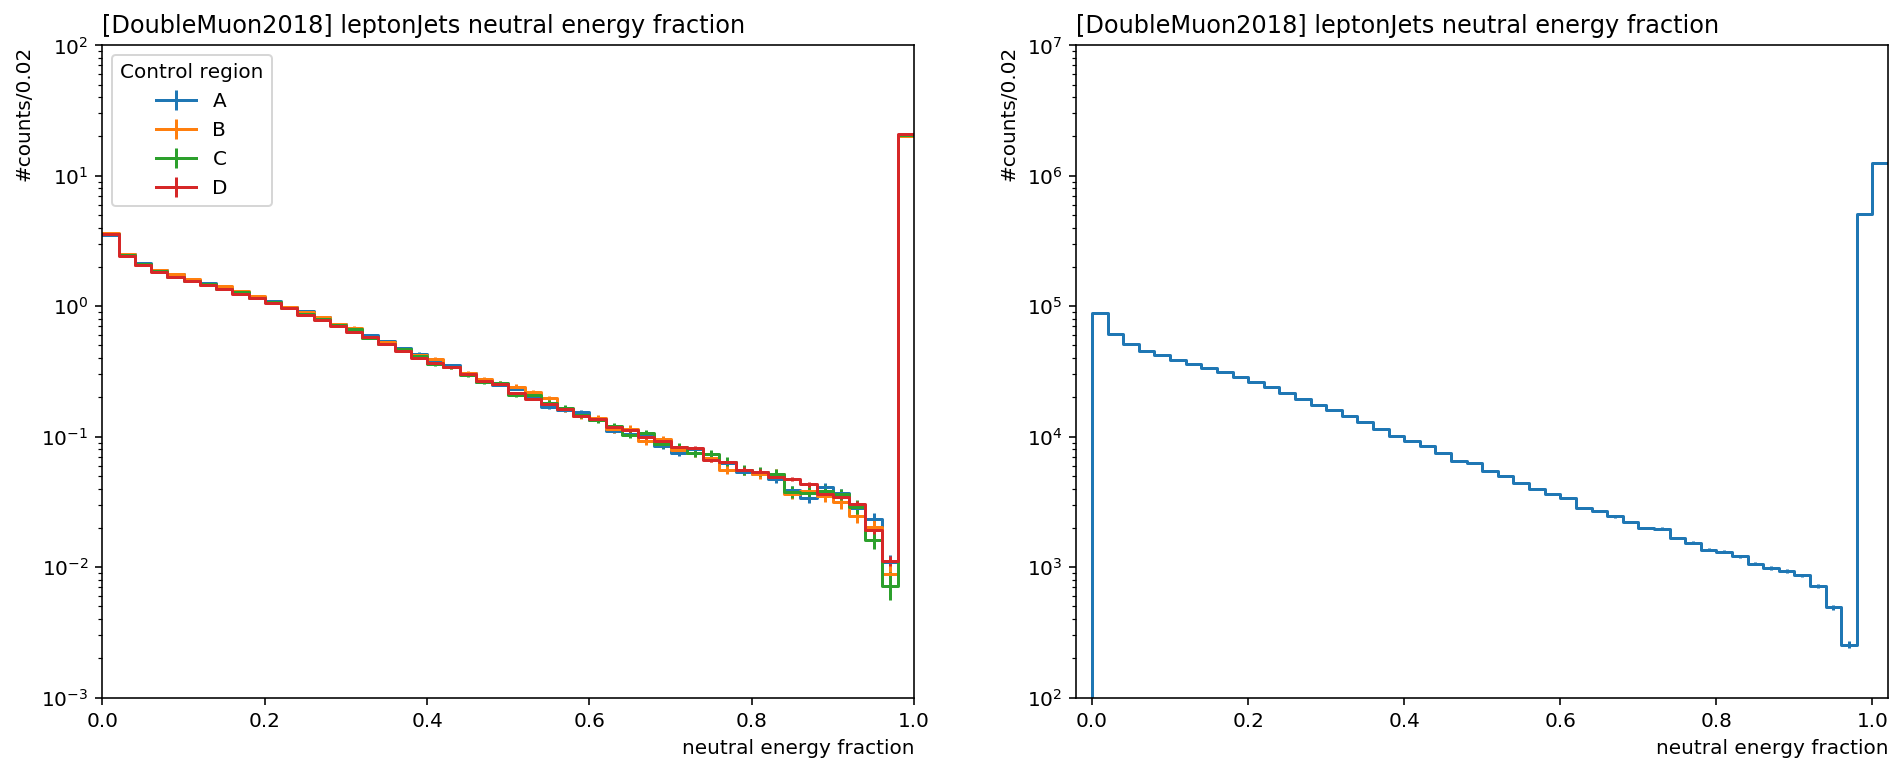

In [14]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['nef'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['nef'].sum('dataset'), ax=axes[1], overflow='all')

axes[0].set_yscale('log')
axes[0].set_ylim([1e-3, 1e2])

axes[1].set_yscale('log')
axes[1].set_ylim([1e2, 1e7])

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets neutral energy fraction', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

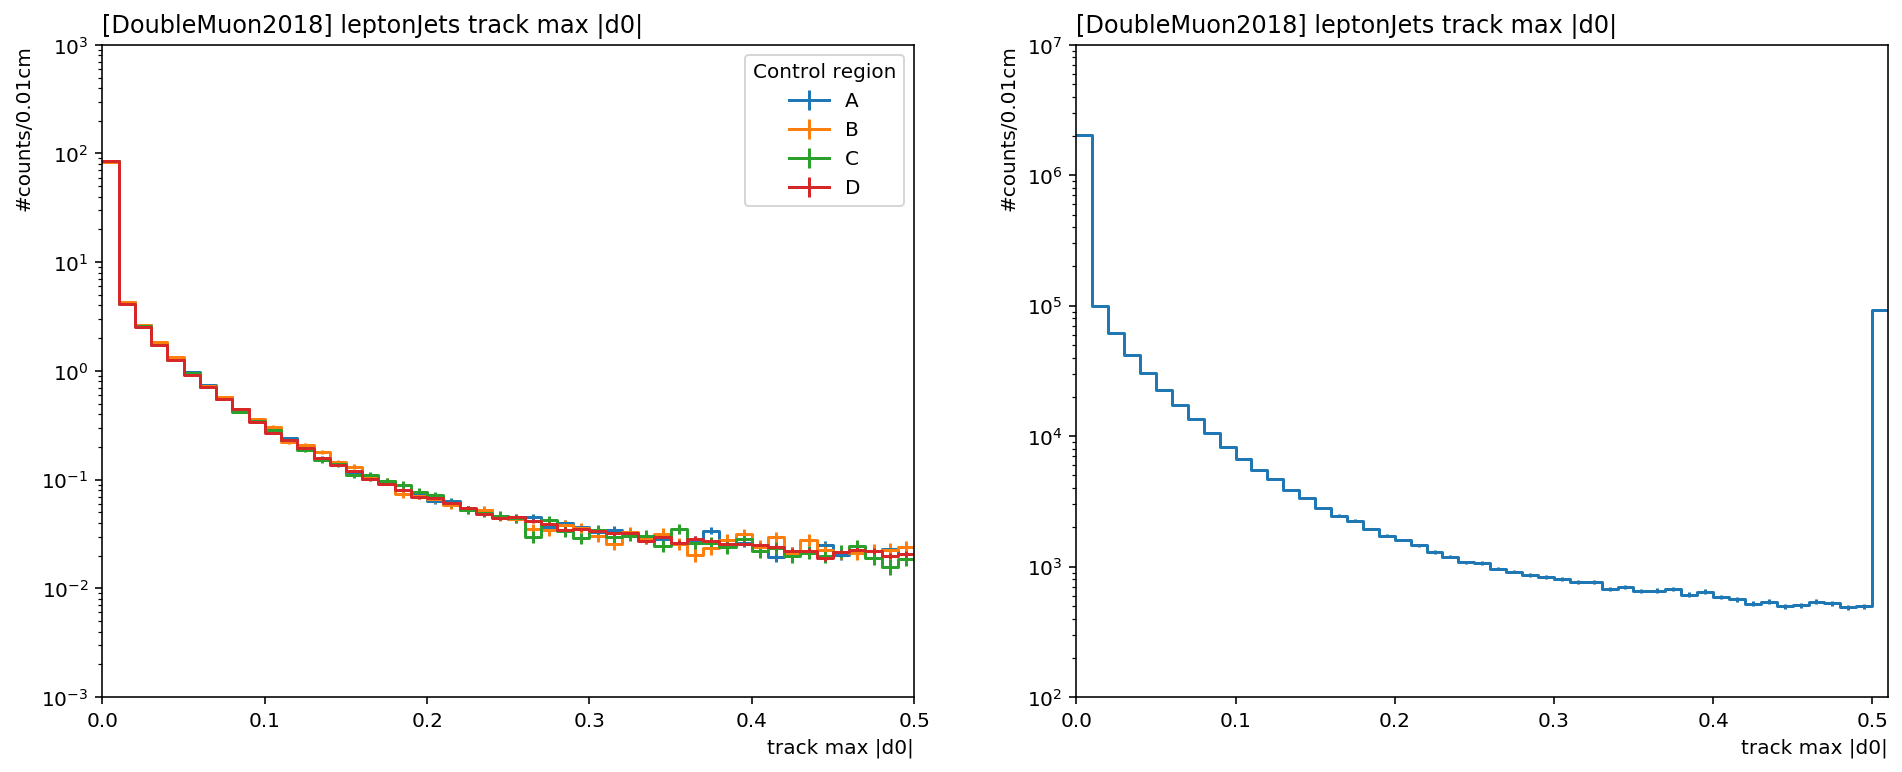

In [15]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['maxd0'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['maxd0'].sum('dataset'), ax=axes[1], overflow='over')

axes[0].set_yscale('log')
axes[0].set_ylim([1e-3, 1e3])
axes[1].set_yscale('log')
axes[1].set_ylim([1e2, 1e7])

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets track max |d0|', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

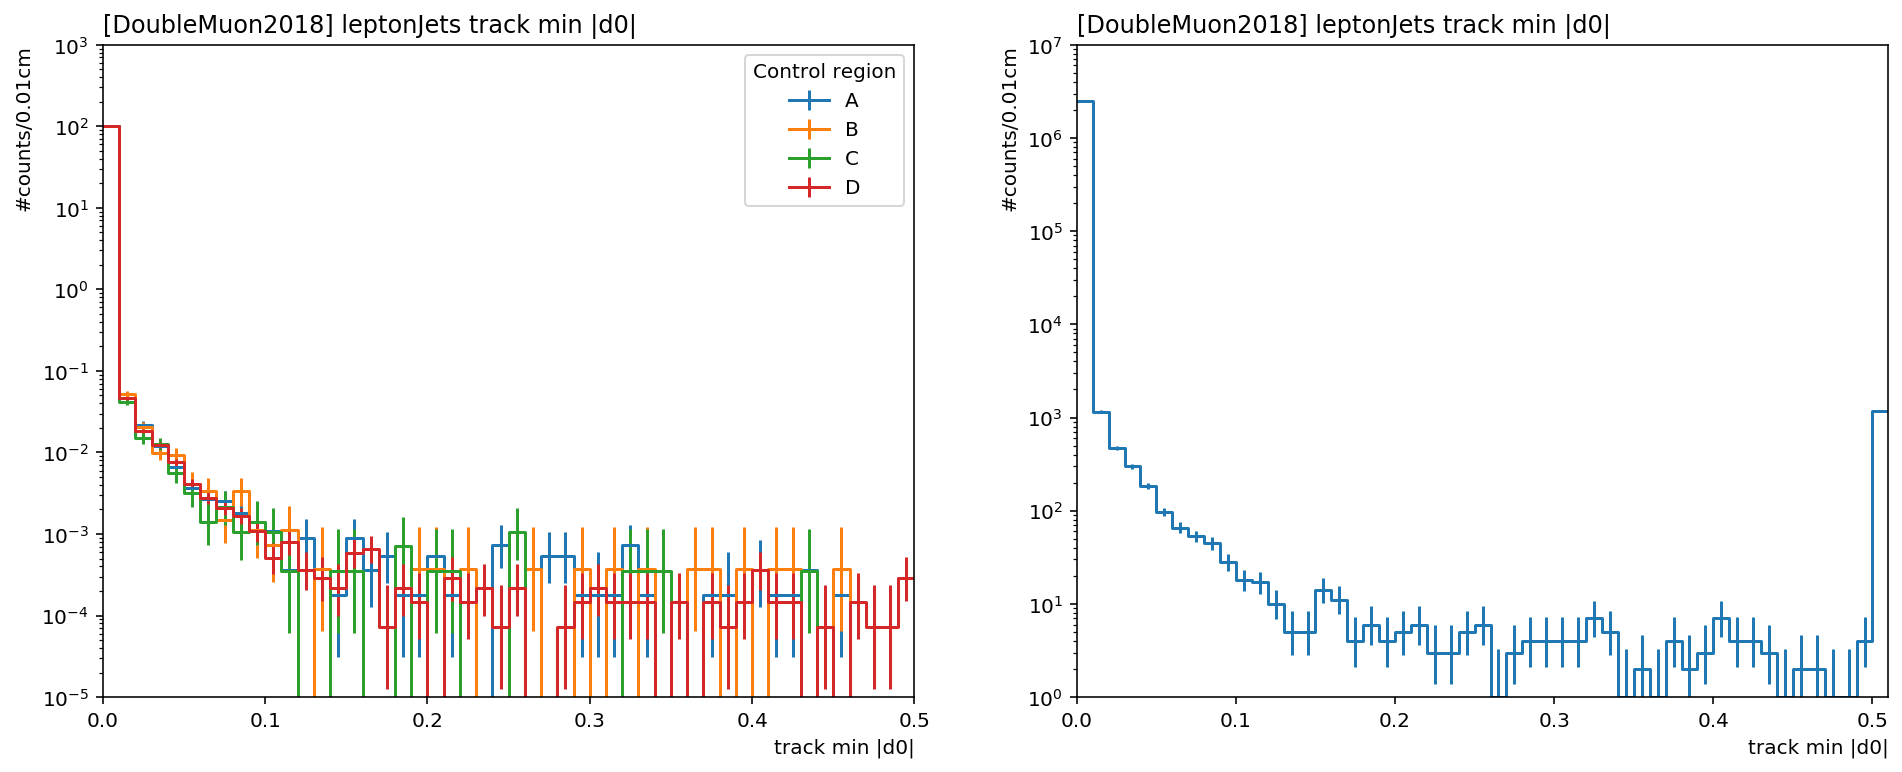

In [16]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['mind0'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['mind0'].sum('dataset'), ax=axes[1], overflow='over')

axes[0].set_yscale('log')
axes[0].set_ylim([1e-5, 1e3])
axes[1].set_yscale('log')
axes[1].set_ylim([1, 1e7])

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets track min |d0|', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

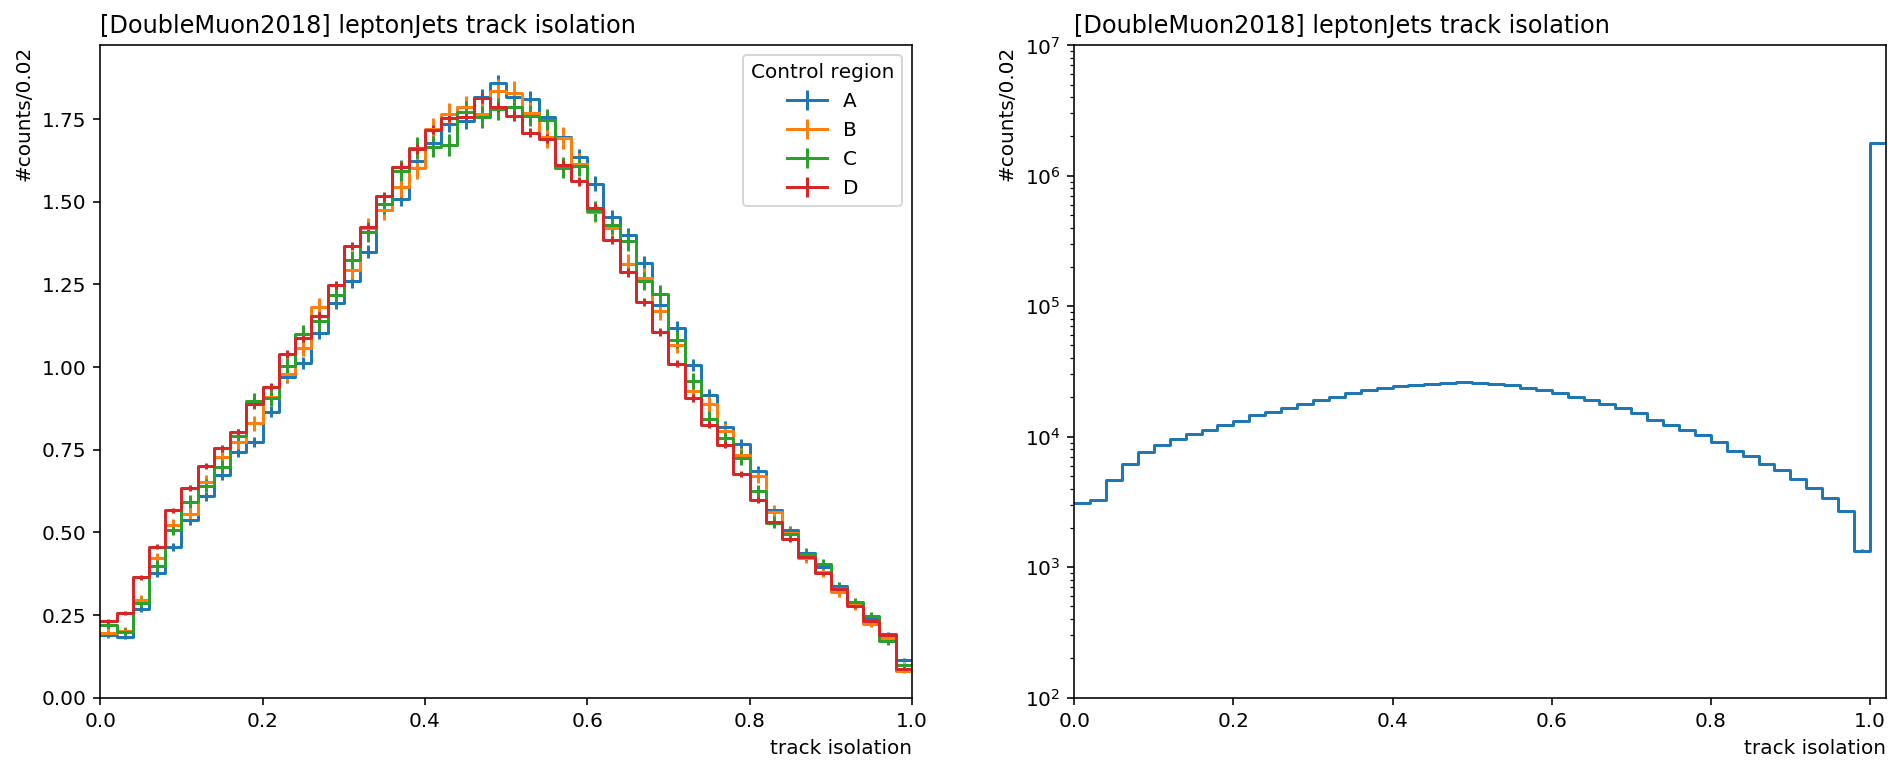

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['tkiso'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['tkiso'].sum('dataset'), ax=axes[1], overflow='over')

axes[1].set_yscale('log')
axes[1].set_ylim([1e2,1e7])

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets track isolation', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

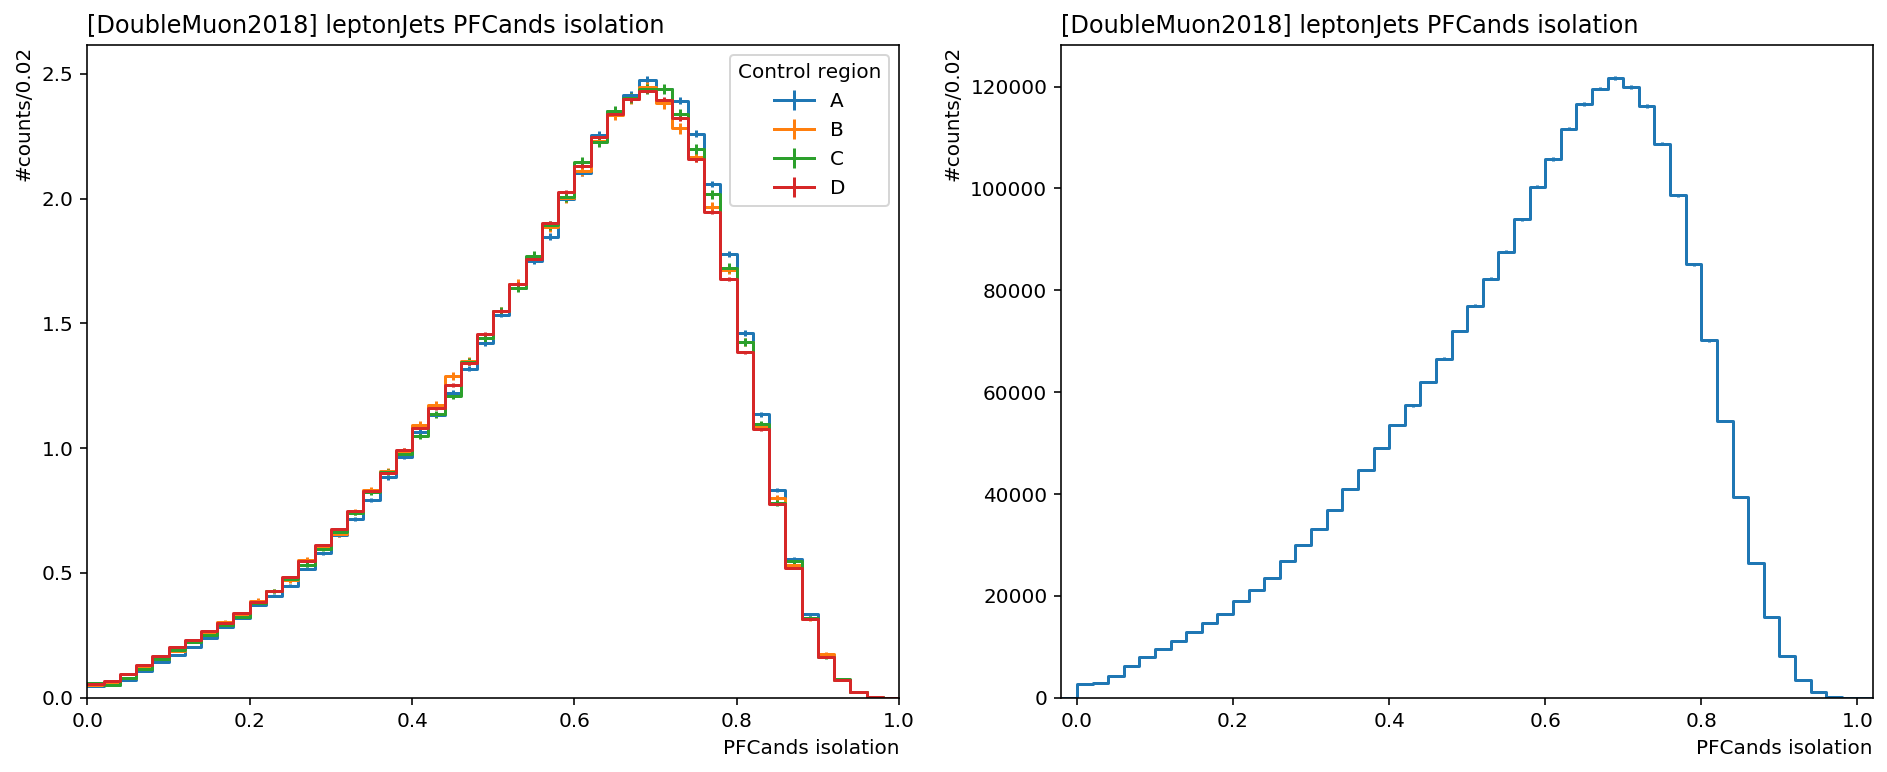

In [18]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['pfiso'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['pfiso'].sum('dataset'), ax=axes[1], overflow='all')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets PFCands isolation', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

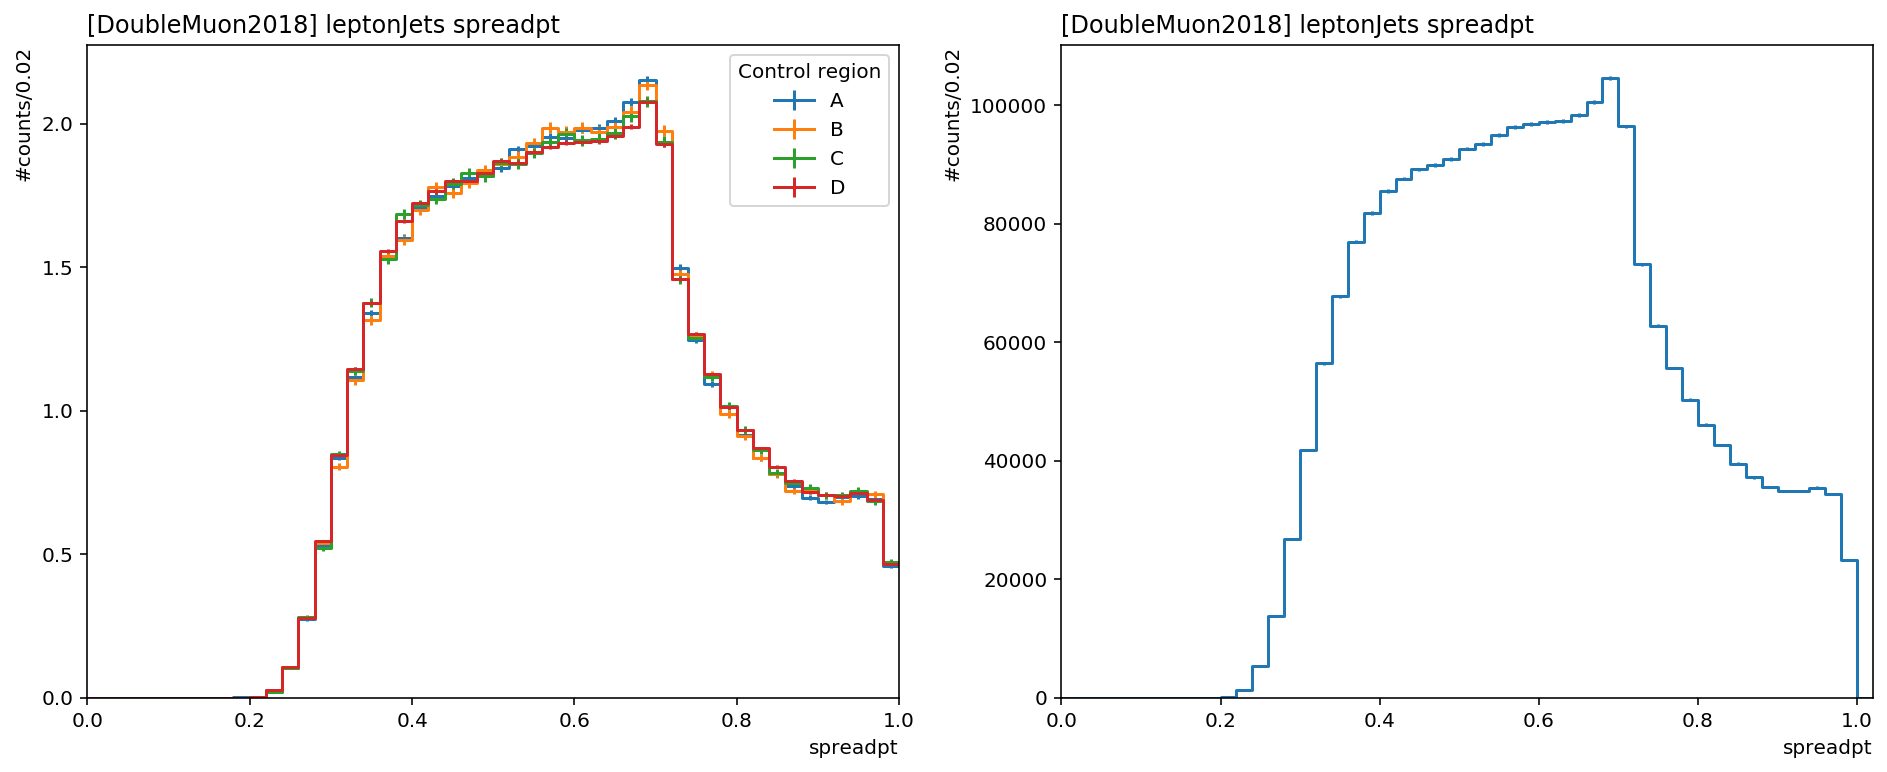

In [19]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['spreadpt'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['spreadpt'].sum('dataset'), ax=axes[1], overflow='over')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets spreadpt', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

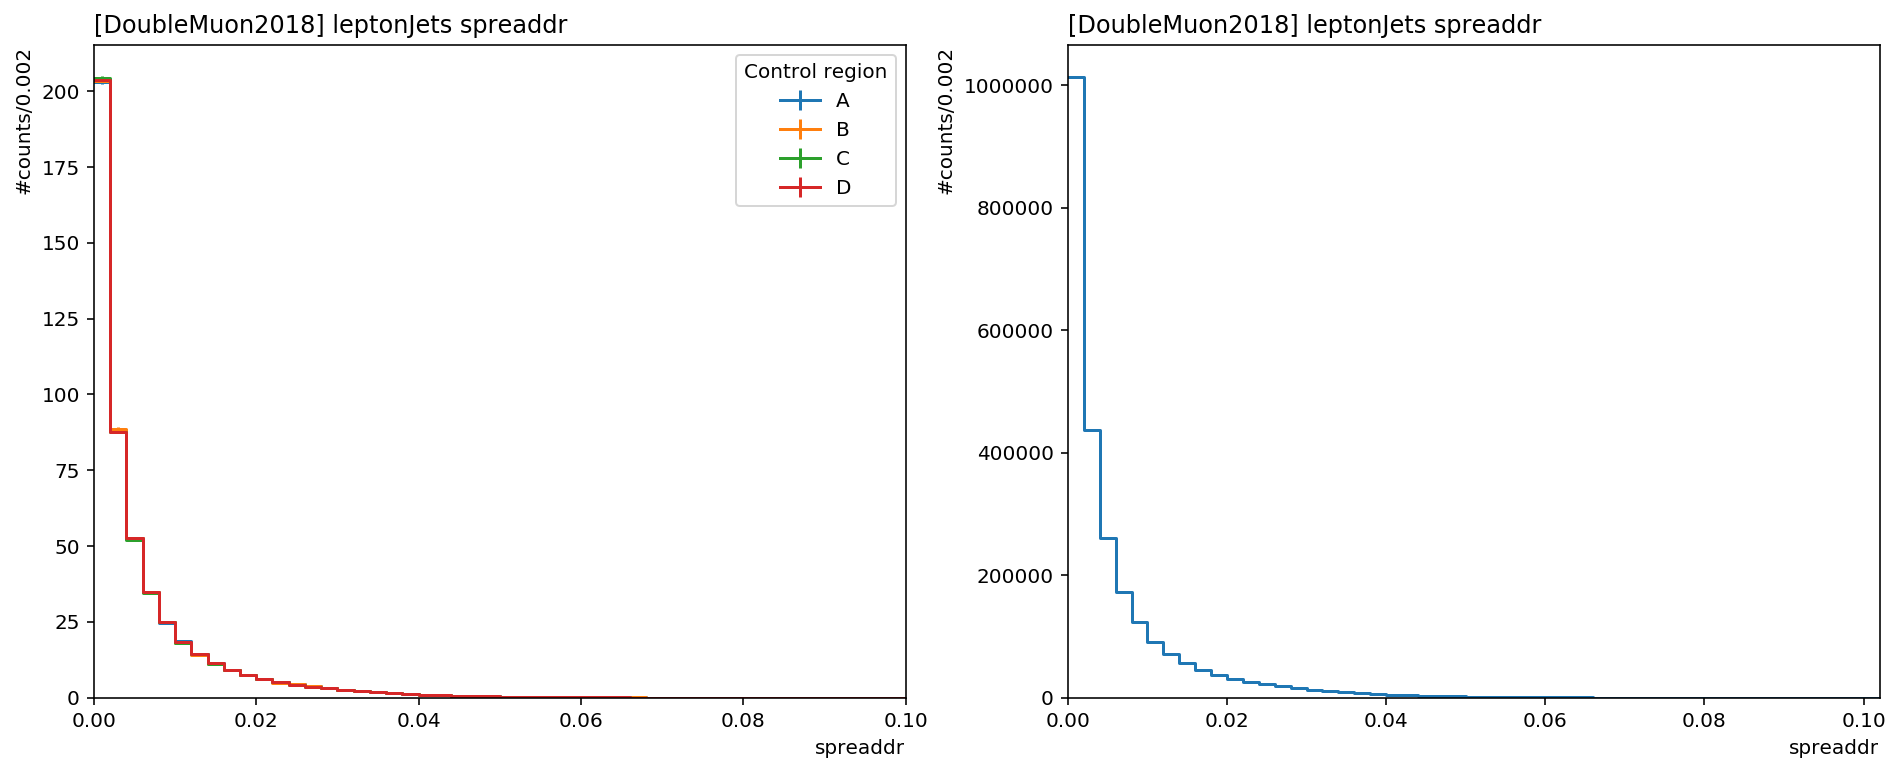

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['spreaddr'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['spreaddr'].sum('dataset'), ax=axes[1], overflow='over')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets spreaddr', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

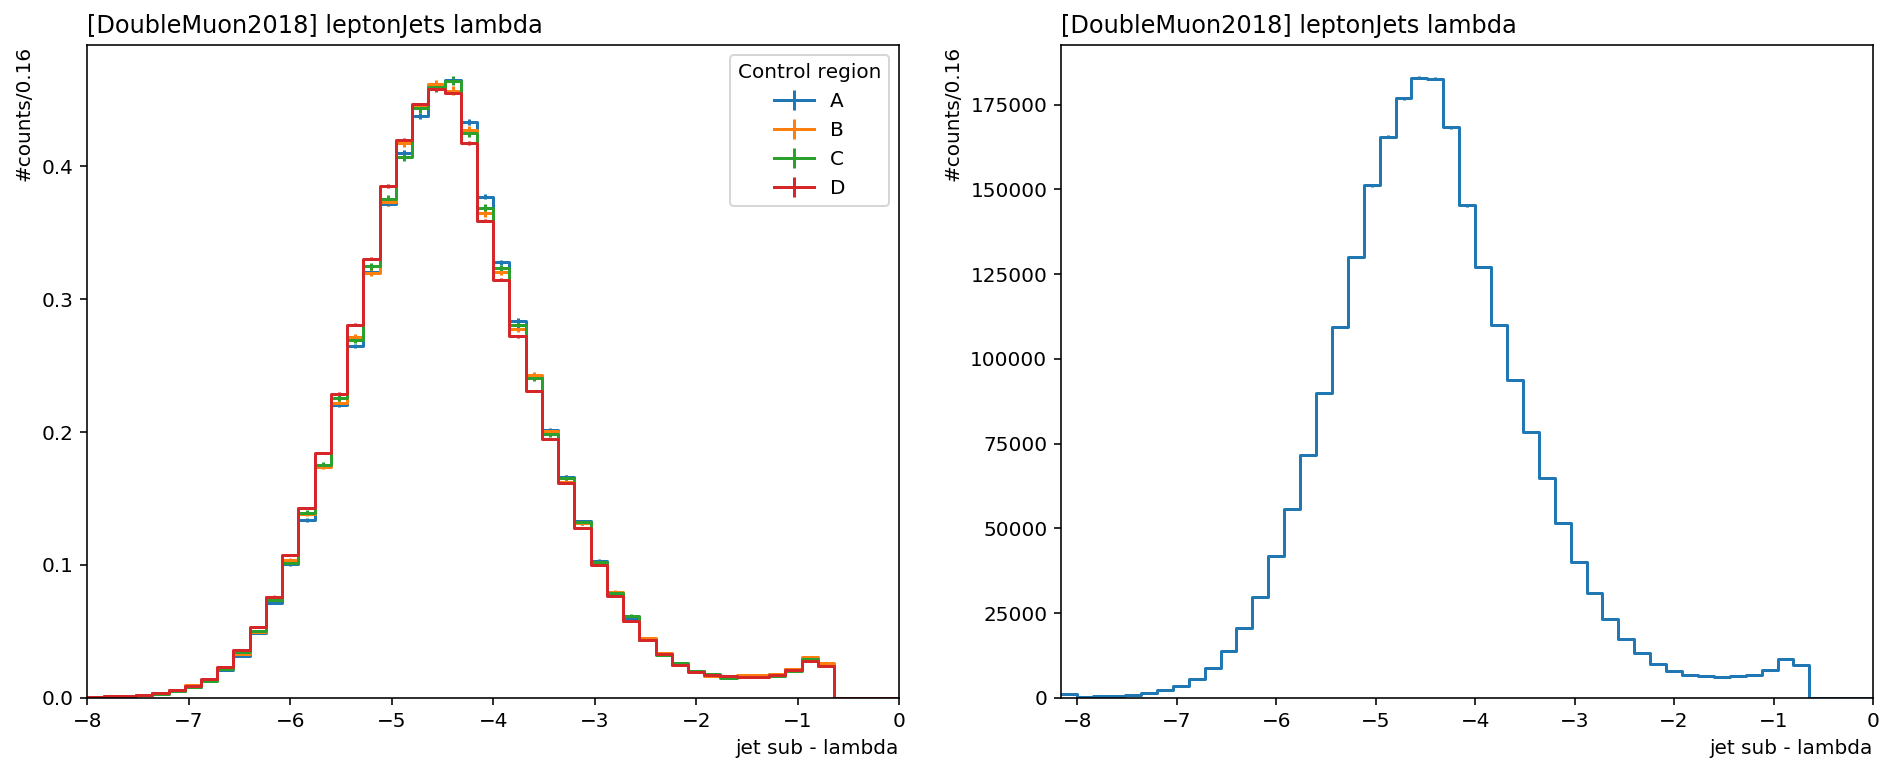

In [21]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lamb'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['lamb'].sum('dataset'), ax=axes[1], overflow='under')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets lambda', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

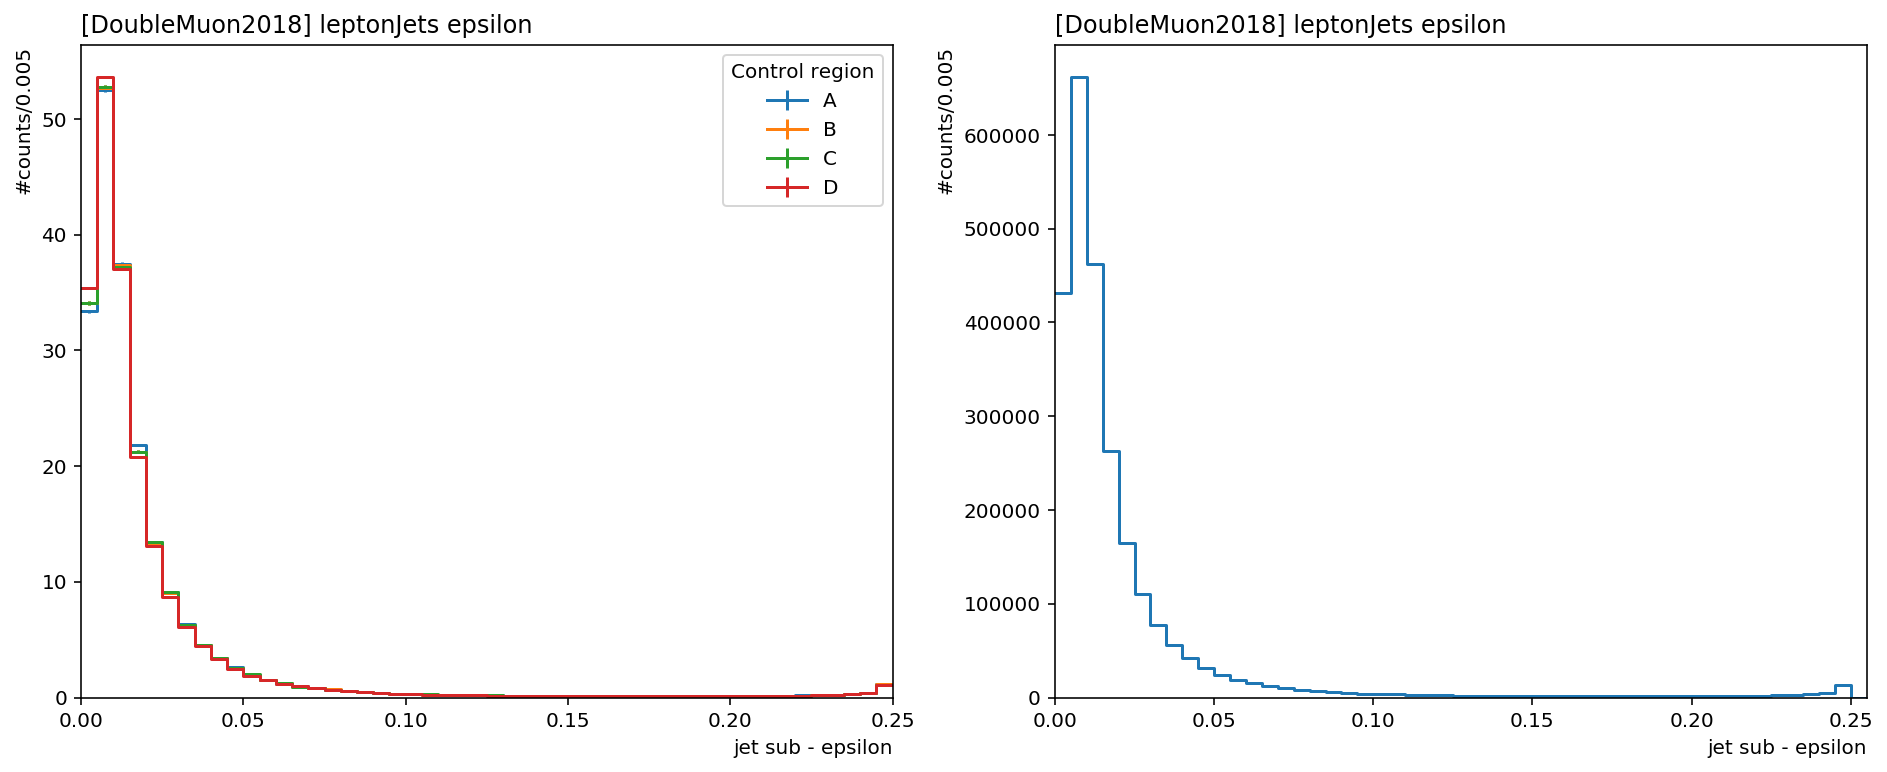

In [22]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['epsi'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['epsi'].sum('dataset'), ax=axes[1], overflow='over')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets epsilon', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

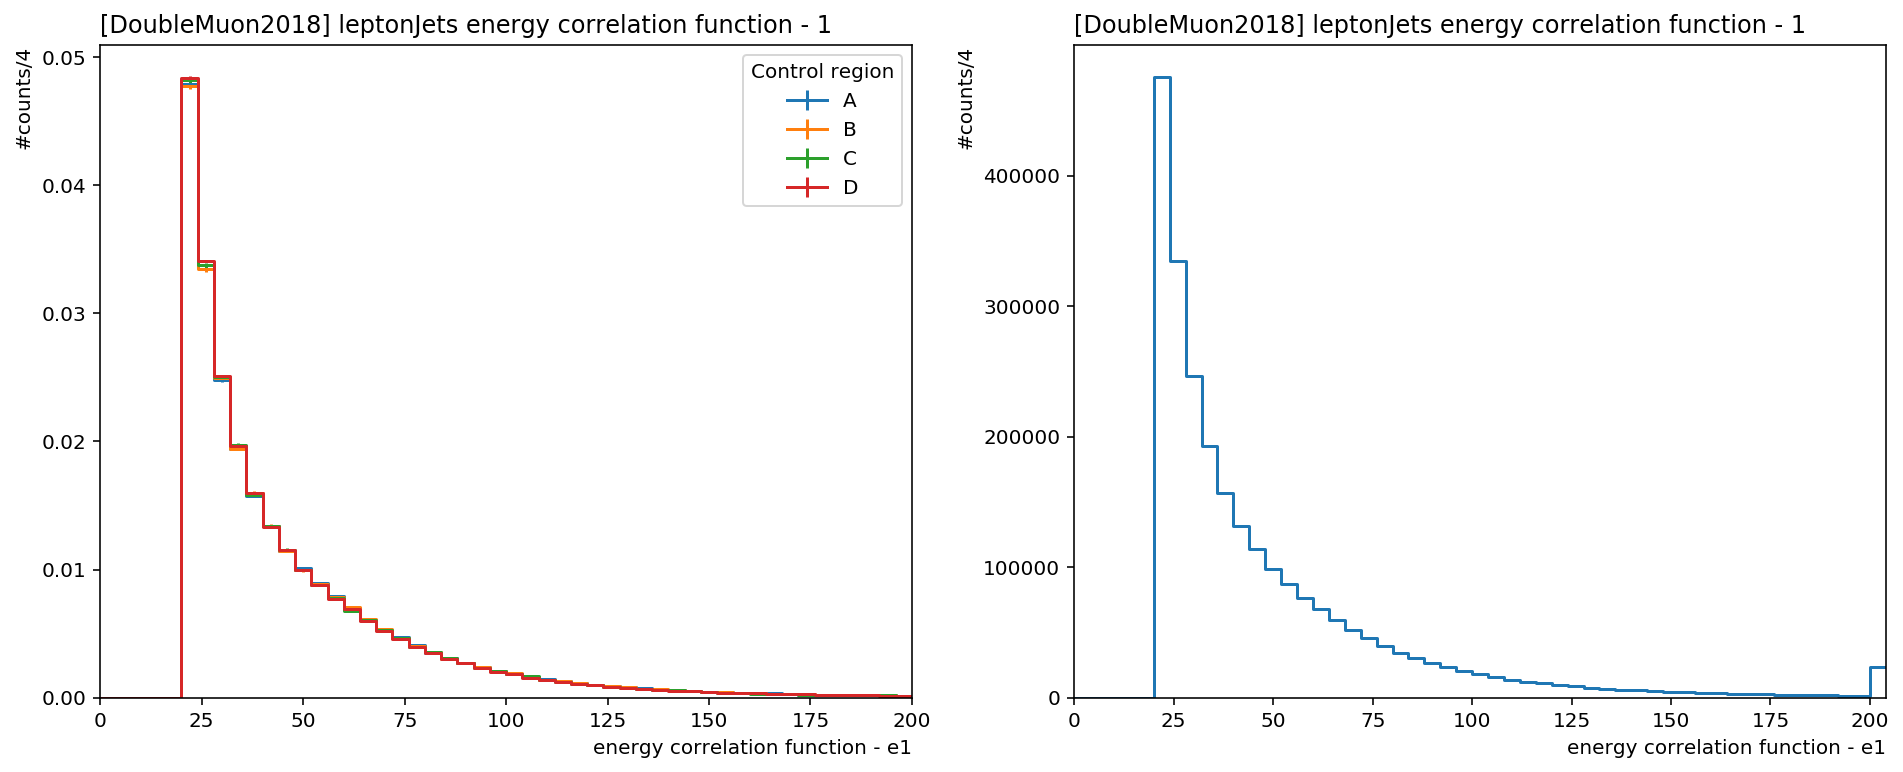

In [23]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['ecfe1'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['ecfe1'].sum('dataset'), ax=axes[1], overflow='over')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets energy correlation function - 1', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

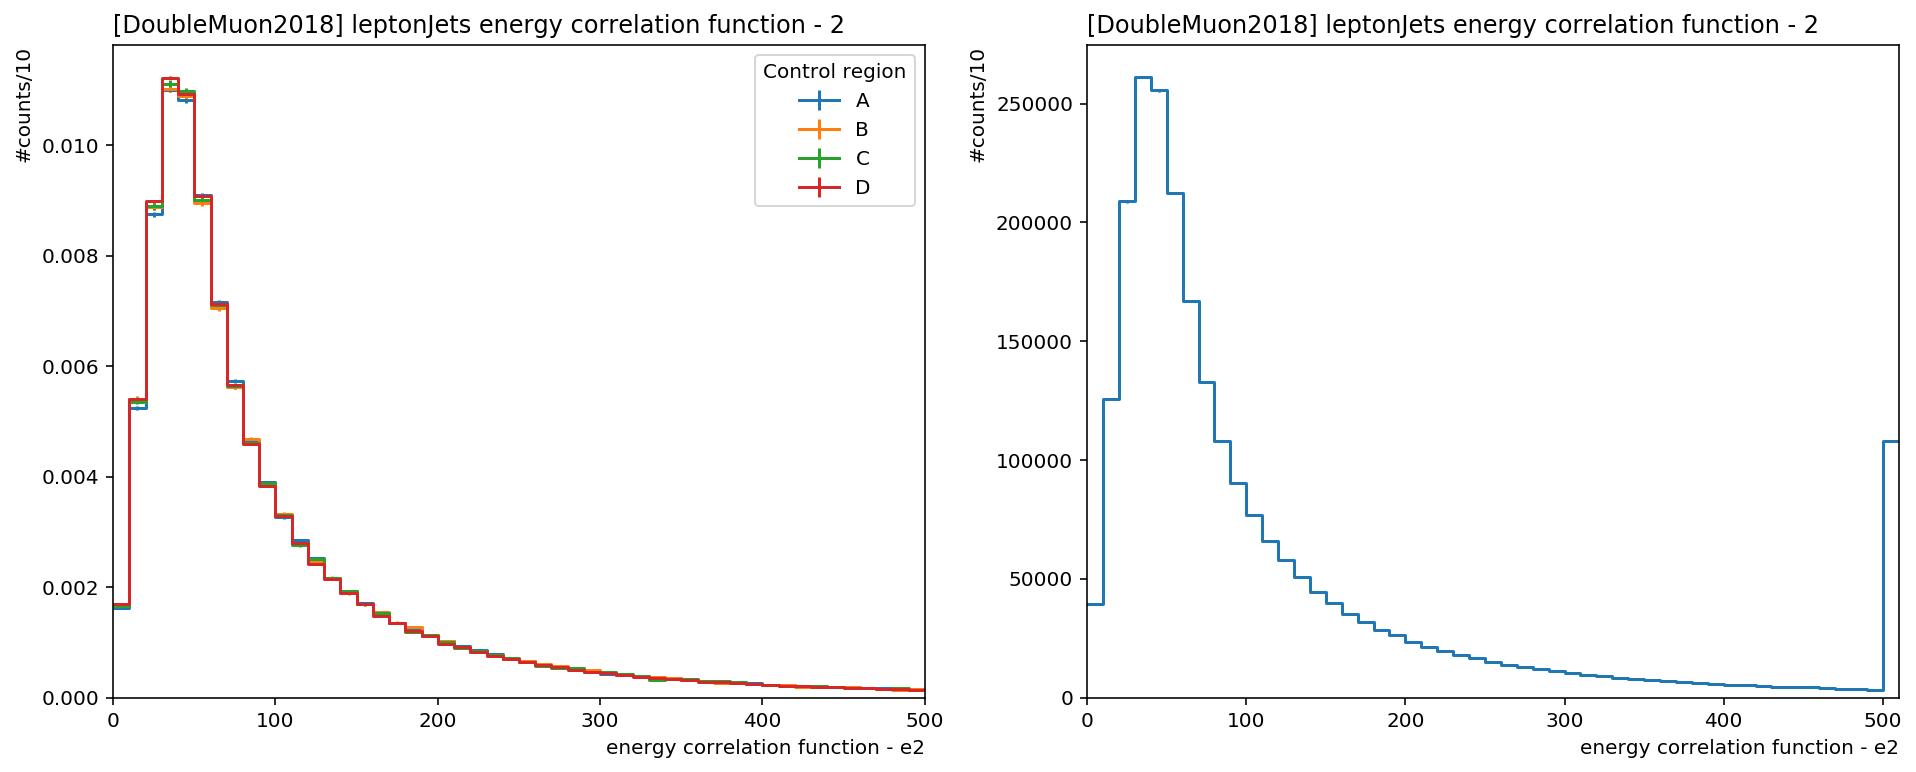

In [24]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['ecfe2'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['ecfe2'].sum('dataset'), ax=axes[1], overflow='over')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets energy correlation function - 2', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

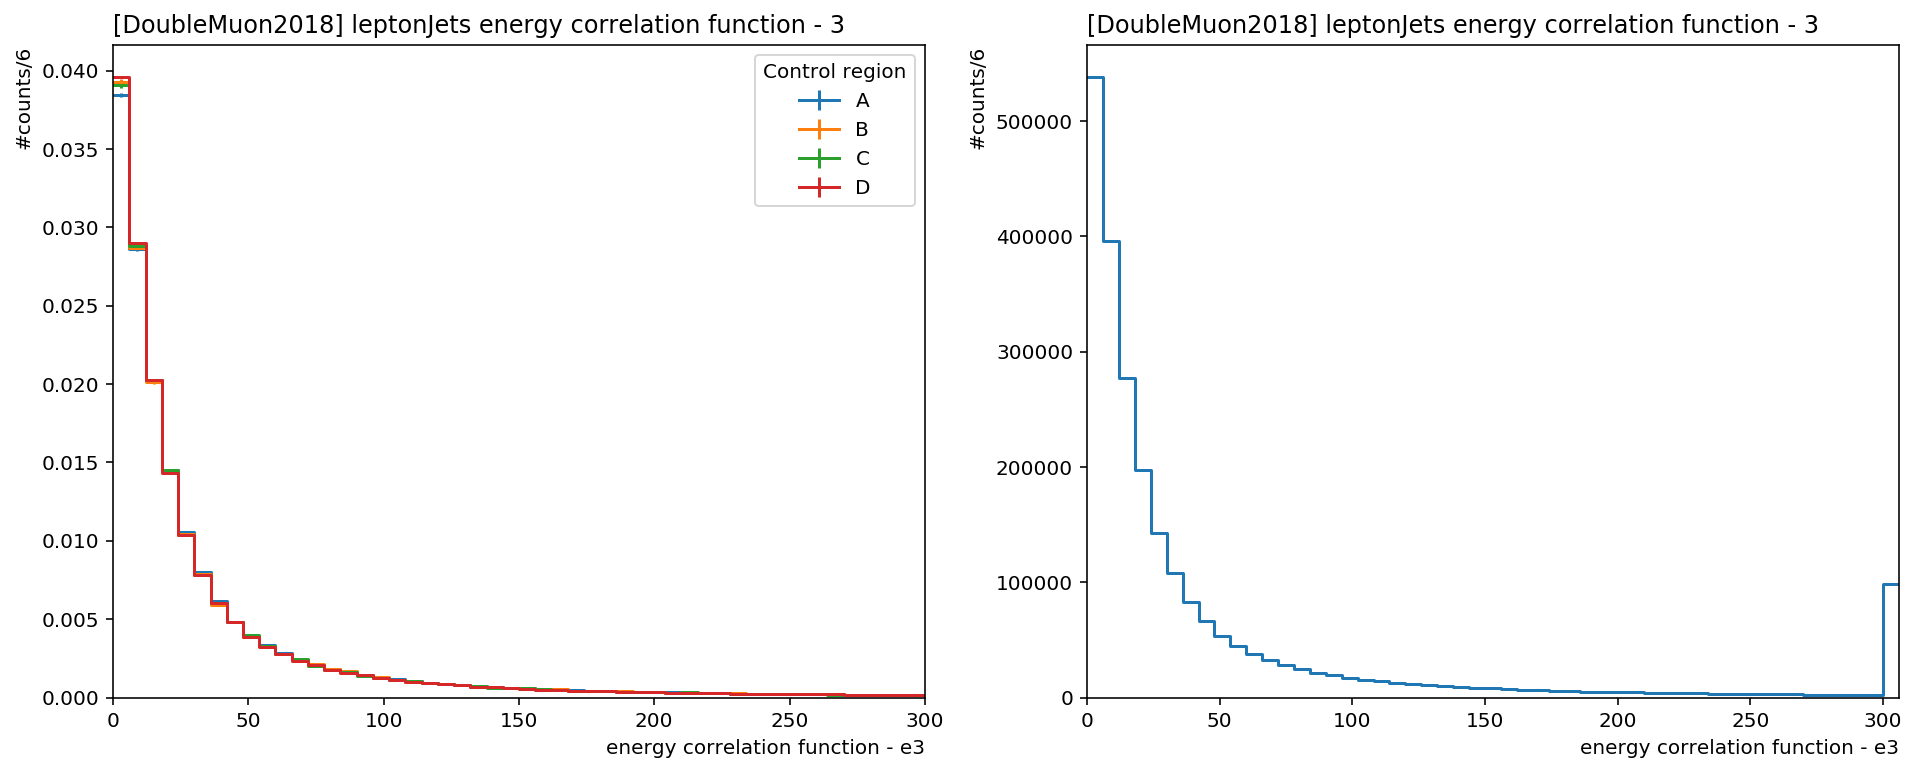

In [25]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['ecfe3'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['ecfe3'].sum('dataset'), ax=axes[1], overflow='over')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets energy correlation function - 3', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

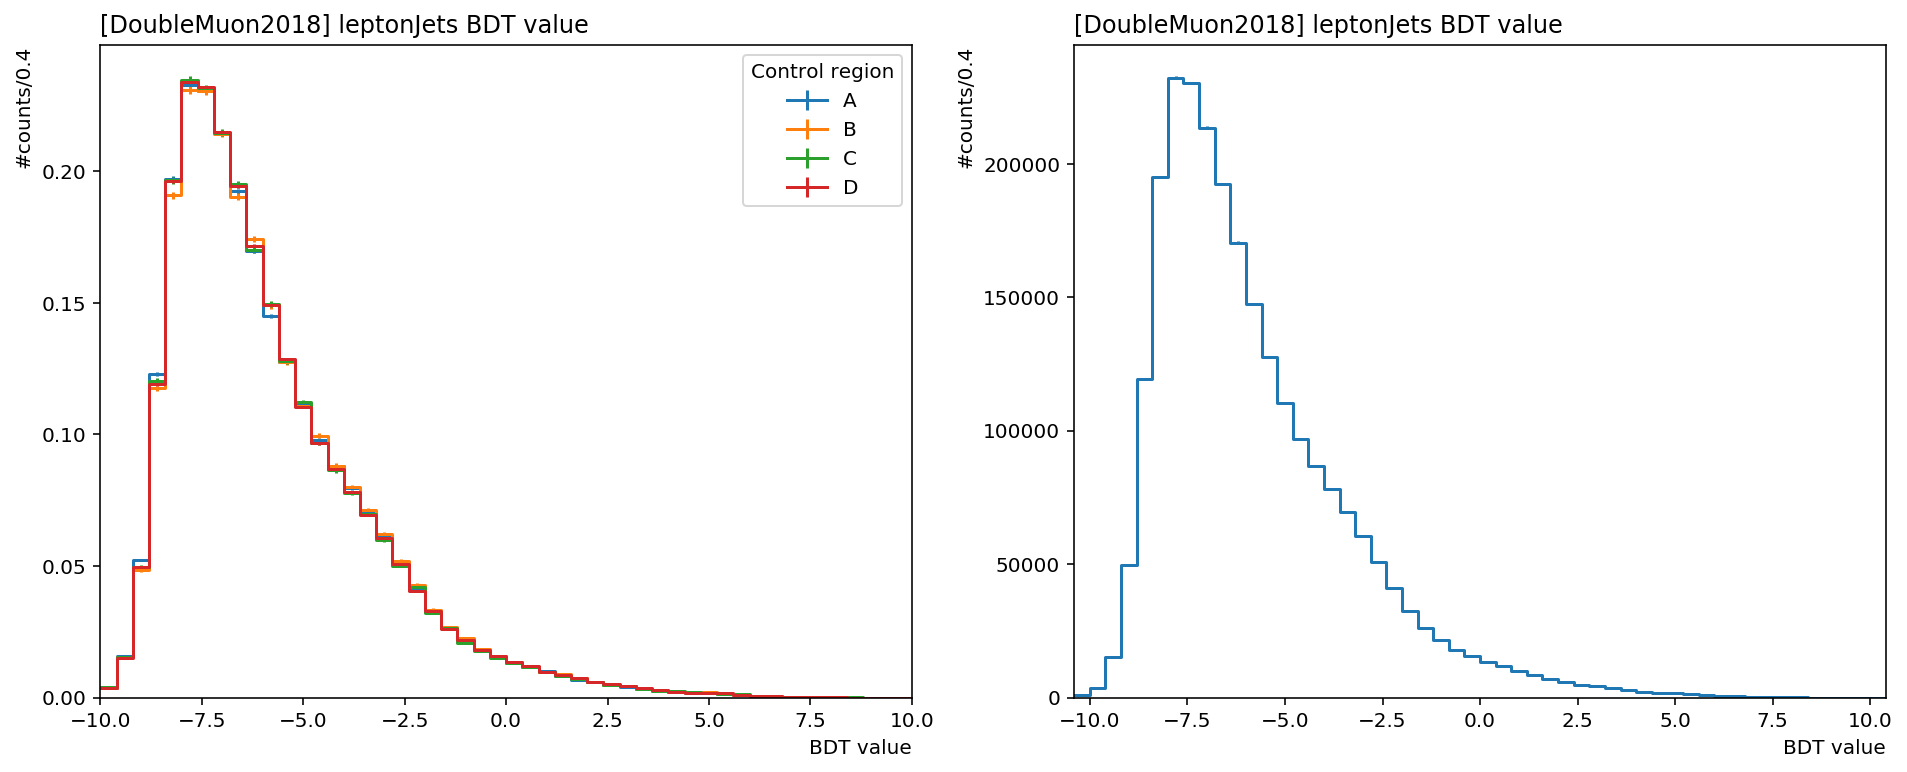

In [26]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['mva'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['mva'].sum('dataset'), ax=axes[1], overflow='all')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets BDT value', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### Invariant mass of leptonJet pair

In [27]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 500)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("#counts/10GeV", dataset_axis, mass_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoljs = leptonjets.counts>=2
        diljs = leptonjets[twoljs]
        diljs = diljs.distincts()
        sumpt = diljs.i0.pt+diljs.i1.pt
        leadDiLjpair = diljs[sumpt.argmax()]
        
        output['mass'].fill(dataset=dataset, mass=leadDiLjpair.mass.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [28]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2545/2545 [01:33<00:00, 27.11items/s]


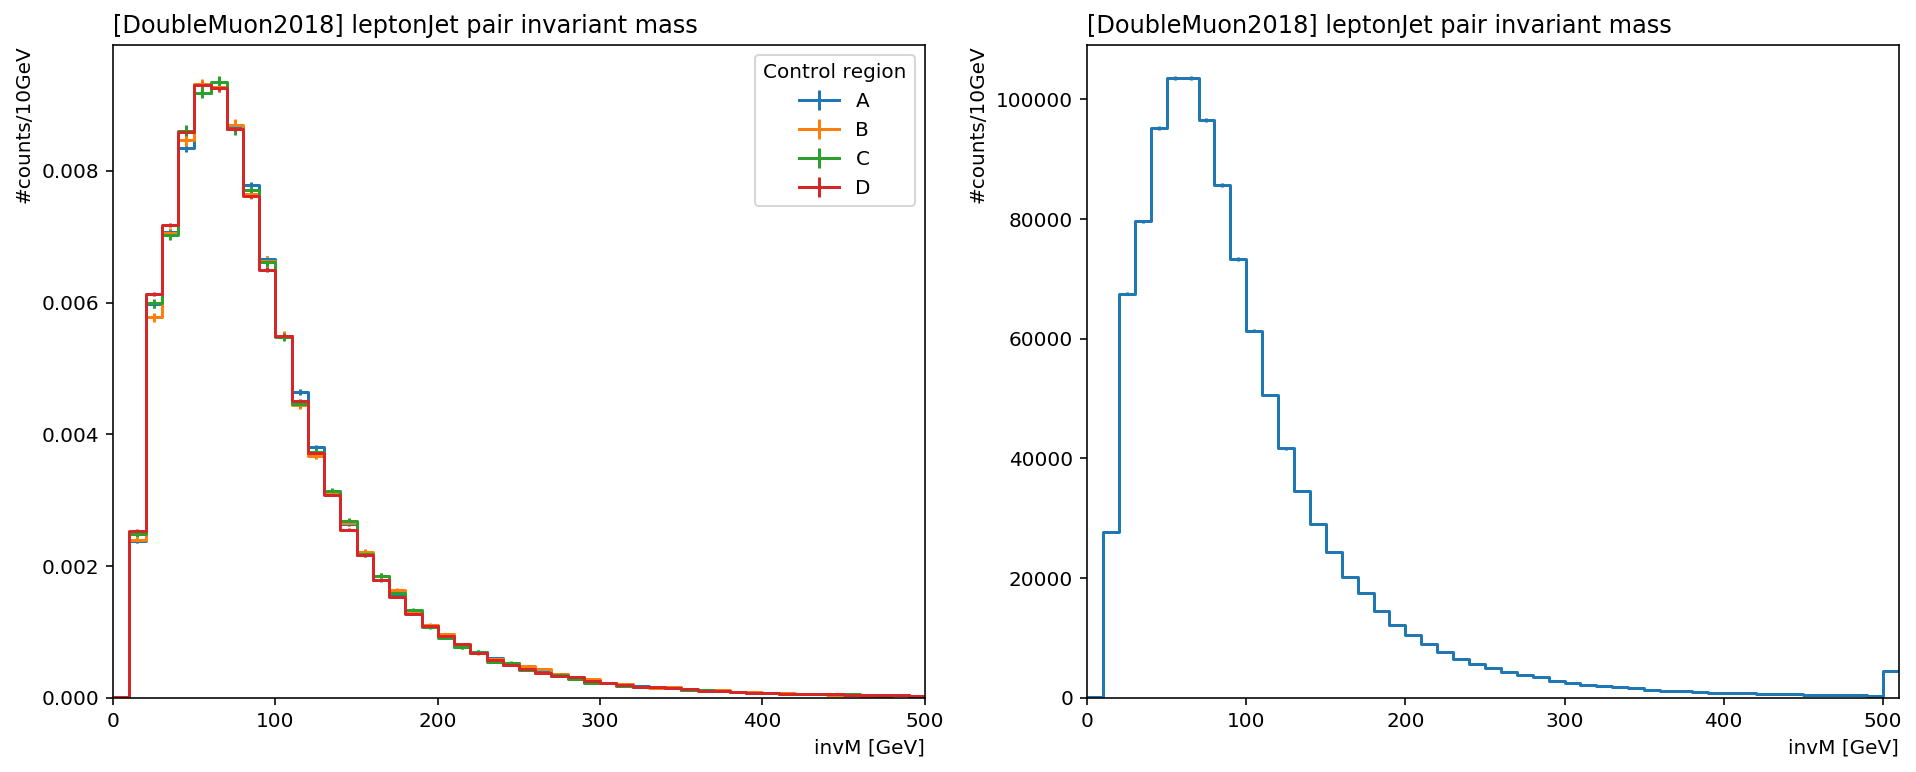

In [29]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['mass'], ax=axes[0], overlay='dataset', density=True)
hist.plot1d(output['mass'].sum('dataset'), ax=axes[1], overflow='over')

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJet pair invariant mass', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

---